# Regressão Linear Múltipla

O objetivo deste notebook é explorar a regressão múltipla e engenharia de atributos com as funções da API Scikit-learn.

Neste notebook você irá manipular dados de transações imobiliárias de King County para prever preços usando regressão múltipla. Desta forma, você poderá:
* Usar Pandas DataFrames para realizar algumas atividades de engenharia de atributos
* Usar funções do Scikit-learn para computar os coeficientes de regressão (pesos/parâmetros)
* Dados os coeficientes de regressão, os preditores e a saída (preços), criar uma função para computar erro utilizando a técnica de mínimos quadrados (Residual Sum of Squares).
* Visualizar os coeficientes e interpretar seus significados

## Importação das bibliotecas

Importação de bibliotecas necessárias para a execução dos comandos:
* Pandas: para manipulação dos dados
* Numpy: para compatibilizar o uso de dados por algumas funções
* Datetime: para formatar um dos atributos da base de dados
* Sklearn: para uso comparativo de funções de regressão linear

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostRegressor
from numpy import mean
from numpy import std

In [2]:
!pip install xgboost
!pip install catboost

### Leitura dos dados

O dataset contém dados de transações imobiliárias de King County, região aonde está a cidade de Seattle, USA.

In [3]:
sales = pd.read_csv("kc_house_data.csv")

## Análise Exploratória dos Dados - Exploratory Data Analysis (EDA) e Pré-processamento

Antes de criarmos o modelo de regressão, vamos primeiro explorar os dados:
* Por meio do uso de algumas funções nativas do Pandas (**.info()** e **.describe()**) é possível extrair uma visão geral dos atributos do dataset;
    * A função *info()* retorna informações específicas sobre os tipos de dados de cada um dos atributos, além de informações sobre uso de memória pela estrutura do mesmo;
    * A função *describe()* retorna informações estatísticas em geral referentes aos dados de cada atributo.

In [4]:
sales.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [6]:
sales.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517      0.766318      0.650743   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068800e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean       7.656873   1788.390691     291.509045   1971.005136     84.402258   
std        1.175459    828.090978     442.575043     29.373411    401.679240   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2210.000000     560.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21613.000000  21613.000000  21613.000000   21613.000000   21613.000000  
mean   98077.939805     47.560053   -122.213896    1986.552492   12768.455652  
std       53.505026      0.138564      0.140828     685.391304   27304.179631  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471000   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.230000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

In [7]:
#Olhando as duplicatas
print(sales.duplicated().any())
num_duplicatas = sales.duplicated().sum()
print("Número de duplicatas:", num_duplicatas)


False
Número de duplicatas: 0


#### Eliminação manual de atributos que direta ou indiretamente não contribuem para o modelo

Remoção dos atributos *'id' e 'date'*

In [8]:
sales.drop(['id'],axis=1,inplace=True)
sales.drop(['date'],axis=1,inplace=True)

#### Verificação de quantos objetos contém valor igual a ZERO para cada um dos parâmetros
Esta análise indica, de imediato, uma "luz vermelha" que devemos considerar quanto aos parâmetros **waterfront**, **view**, **yr_renovated** e **sqft_basement**. 
* Quase todos os parâmetros contém aproximadamente **90%** ou mais de seus dados com valor igual a zero.

In [62]:
(sales[sales[sales.columns] == 0]).count()

price                0
bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
waterfront       21450
view             19489
condition            0
grade                0
sqft_above           0
sqft_basement    13126
yr_built             0
yr_renovated     20699
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

#### Verificação de quantos valores únicos cada atributo possui
Esta verificação foi realizada para se ter uma visão geral dos intervalos de valores que cada atributo apresenta.

In [63]:
sales.nunique()

price            4028
bedrooms           13
bathrooms          30
sqft_living      1038
sqft_lot         9782
floors              6
waterfront          2
view                5
condition           5
grade              12
sqft_above        946
sqft_basement     306
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
sqft_living15     777
sqft_lot15       8689
dtype: int64

#### verificação de únicos:

In [64]:
unicos_bath = sales['bathrooms'].unique()
banheiros=unicos_bath.astype(str)
print("Banheiros : ",banheiros)
unicos_view = sales['view'].unique()
view=unicos_view.astype(str)
print("view: ",view)
unicos_condition = sales['condition'].unique()
condition=unicos_condition.astype(str)
print("Condition: ",condition)
unicos_grade = sales['grade'].unique()
grade=unicos_grade.astype(str)
print("Grade: ",grade)
unicos_zip= sales['zipcode'].unique()
zipcode=unicos_zip.astype(str)
print("Zipcode: ",zipcode)
unicos_waterfront = sales['waterfront'].unique()
waterfront=unicos_waterfront.astype(str)
print("Waterfront: ",waterfront)



Banheiros :  ['1.0' '2.25' '3.0' '2.0' '4.5' '1.5' '2.5' '1.75' '2.75' '3.25' '4.0'
 '3.5' '0.75' '4.75' '5.0' '4.25' '3.75' '0.0' '1.25' '5.25' '6.0' '0.5'
 '5.5' '6.75' '5.75' '8.0' '7.5' '7.75' '6.25' '6.5']
view:  ['0' '3' '4' '2' '1']
Condition:  ['3' '5' '4' '1' '2']
Grade:  ['7' '6' '8' '11' '9' '5' '10' '12' '4' '3' '13' '1']
Zipcode:  ['98178' '98125' '98028' '98136' '98074' '98053' '98003' '98198' '98146'
 '98038' '98007' '98115' '98107' '98126' '98019' '98103' '98002' '98133'
 '98040' '98092' '98030' '98119' '98112' '98052' '98027' '98117' '98058'
 '98001' '98056' '98166' '98023' '98070' '98148' '98105' '98042' '98008'
 '98059' '98122' '98144' '98004' '98005' '98034' '98075' '98116' '98010'
 '98118' '98199' '98032' '98045' '98102' '98077' '98108' '98168' '98177'
 '98065' '98029' '98006' '98109' '98022' '98033' '98155' '98024' '98011'
 '98031' '98106' '98072' '98188' '98014' '98055' '98039']
Waterfront:  ['0' '1']


### Gráficos

#### Distribuição dos preços pela localização

<Axes: title={'center': 'Preços por localização'}, xlabel='long', ylabel='lat'>

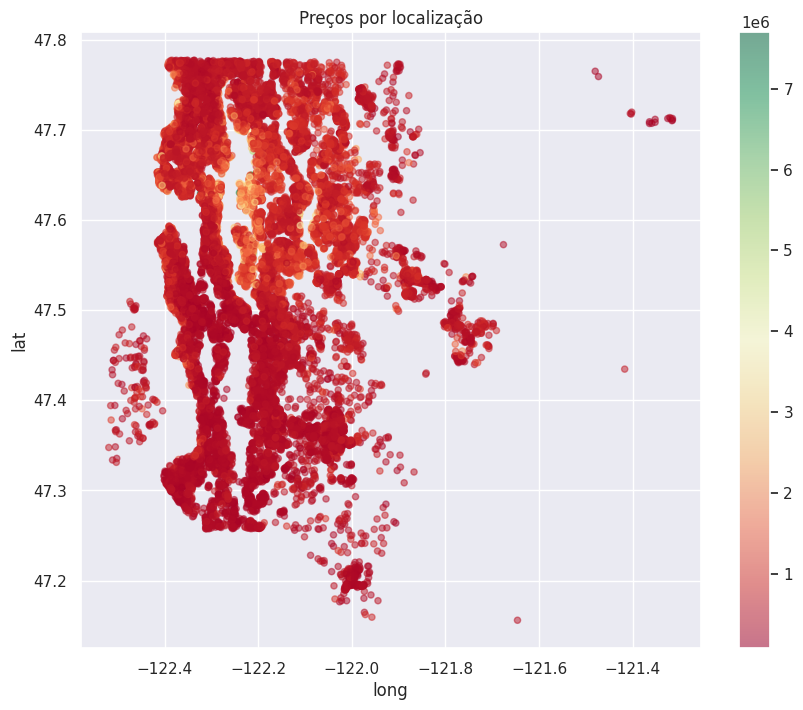

In [65]:
sales.plot.scatter(y='lat',x='long',c=sales['price'],cmap ='RdYlGn', 
                   alpha=0.5, figsize=(10,8),title = "Preços por localização")

Média dos valores do preço dividindo a area em  50x50 hexágonos

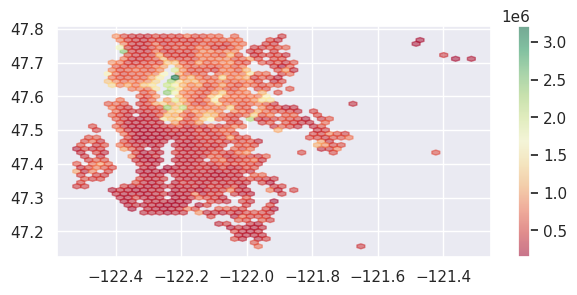

In [66]:
hb =plt.hexbin(x=sales['long'], y=sales['lat'], C=sales['price'], gridsize=50, cmap='RdYlGn', alpha=0.5)
plt.colorbar()


In [68]:
from IPython.display import Image, display

#### Mapa do condado


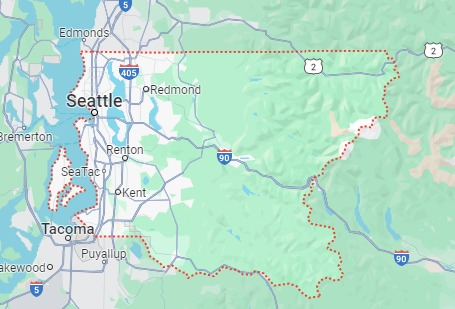

In [69]:
display(Image(filename='condado.jpeg'))

### Nota da construção e design

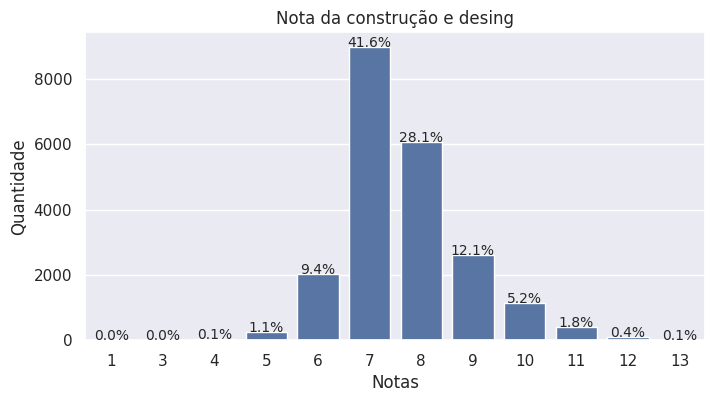

In [70]:
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.countplot(x='grade', data=sales)
total = len(sales['grade'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.1,
            f'{height / total:.1%}',
            ha="center",fontsize=10)
# Adiciona rótulos aos eixos
plt.title('Nota da construção e desing')
plt.xlabel('Notas')
plt.ylabel('Quantidade')

# Exibe o gráfico
plt.show()

Possível ver que não existem notas em 1 e 3 e que a maioria está com nota 7 e 8 que são notas médias, segundo legenda do dataset.
Para melhor visualização será feito um gráfico com intervalo de notas

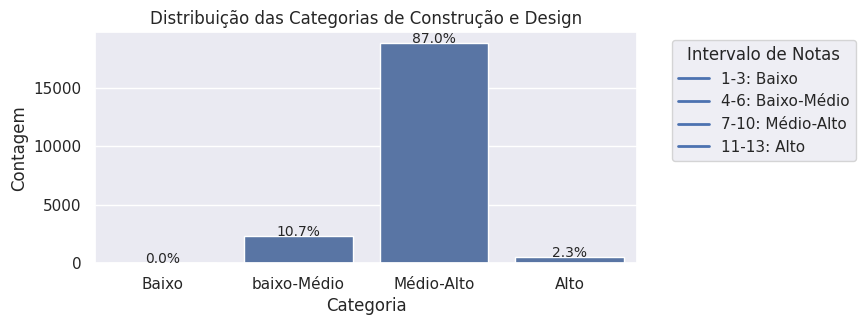

In [71]:
categorias = {
    'Baixo': range(1, 4),
    'baixo-Médio': range(4, 7),
    'Médio-Alto': range(7, 11),
    'Alto': range(11, 14)
}

novo_dataframe = sales.copy()  
novo_dataframe['Categoria'] = novo_dataframe['grade'].apply(
    lambda x: next((categoria for categoria, intervalo in categorias.items() if x in intervalo), None)
)

sns.set(rc={'figure.figsize':(7, 3)})

ax = sns.countplot(x='Categoria', data=novo_dataframe , order=['Baixo', 'baixo-Médio', 'Médio-Alto', 'Alto'])

# Adiciona porcentagens em cima das barras
total = len(novo_dataframe['Categoria'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.1,
            f'{height / total:.1%}',
            ha="center",fontsize=10)


plt.title('Distribuição das Categorias de Construção e Design')
plt.xlabel('Categoria')
plt.ylabel('Contagem')

rótulos_personalizados = ['1-3: Baixo', '4-6: Baixo-Médio', '7-10: Médio-Alto', '11-13: Alto']
legendas = [plt.Line2D([0], [0], lw=2) for i in range(len(categorias))]
ax.legend(legendas, rótulos_personalizados, title='Intervalo de Notas', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


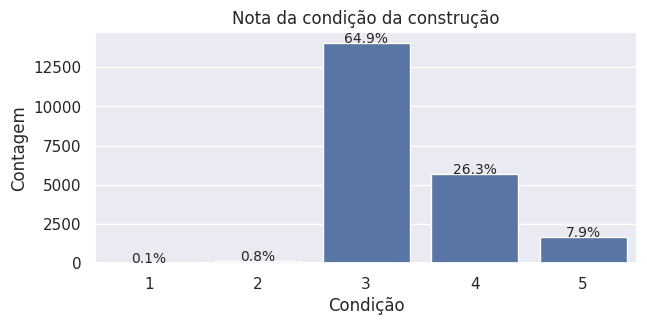

In [39]:
sns.set(rc={'figure.figsize':(7,3)})
ax = sns.countplot(x='condition', data=sales);
total = len(sales['condition'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.1,
            f'{height / total:.1%}',
            ha="center",fontsize=10)
plt.title('Nota da condição da construção')

# Adiciona rótulos aos eixos
plt.xlabel('Condição')
plt.ylabel('Contagem')
plt.show()

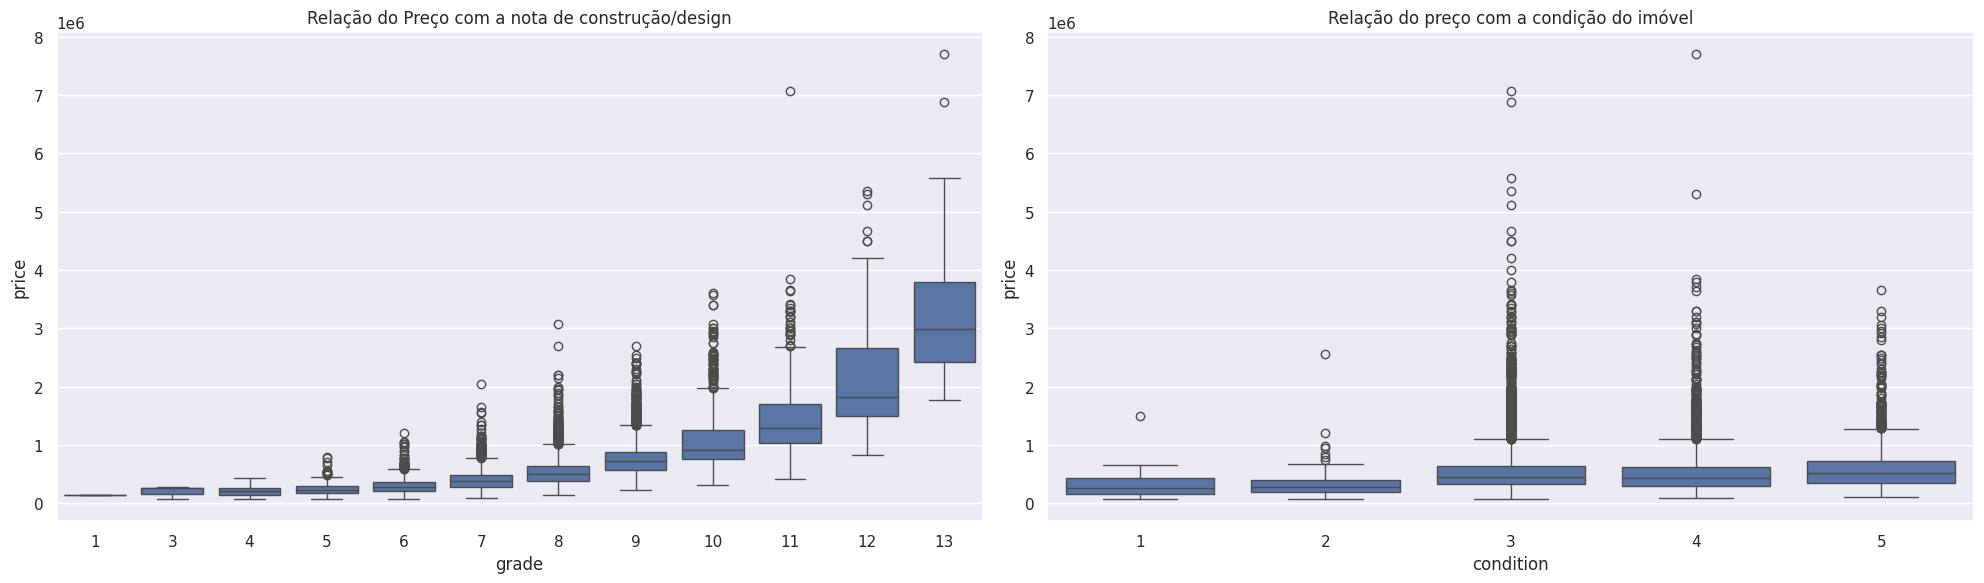

In [72]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.boxplot(x='grade', y='price', data=sales, ax=axes[0])
axes[0].set_title('Relação do Preço com a nota de construção/design')
sns.boxplot(x='condition', y='price', data=sales, ax=axes[1])
axes[1].set_title('Relação do preço com a condição do imóvel')
plt.tight_layout()

plt.show()


Os maiores preços estão nas casas com maiores notas de construção e design, o mesmo ocorreu com a condição, mas na condição 3 existem os maiores valores, apesar da média ser mais baixa

In [73]:
#quantidade de imóveis com e sem vista para o mar
sales["waterfront"].value_counts()

waterfront
0    21450
1      163
Name: count, dtype: int64

In [74]:
sales["bedrooms"].value_counts()

bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64

#### Matriz correlação (apenas das maiores de 0.5)

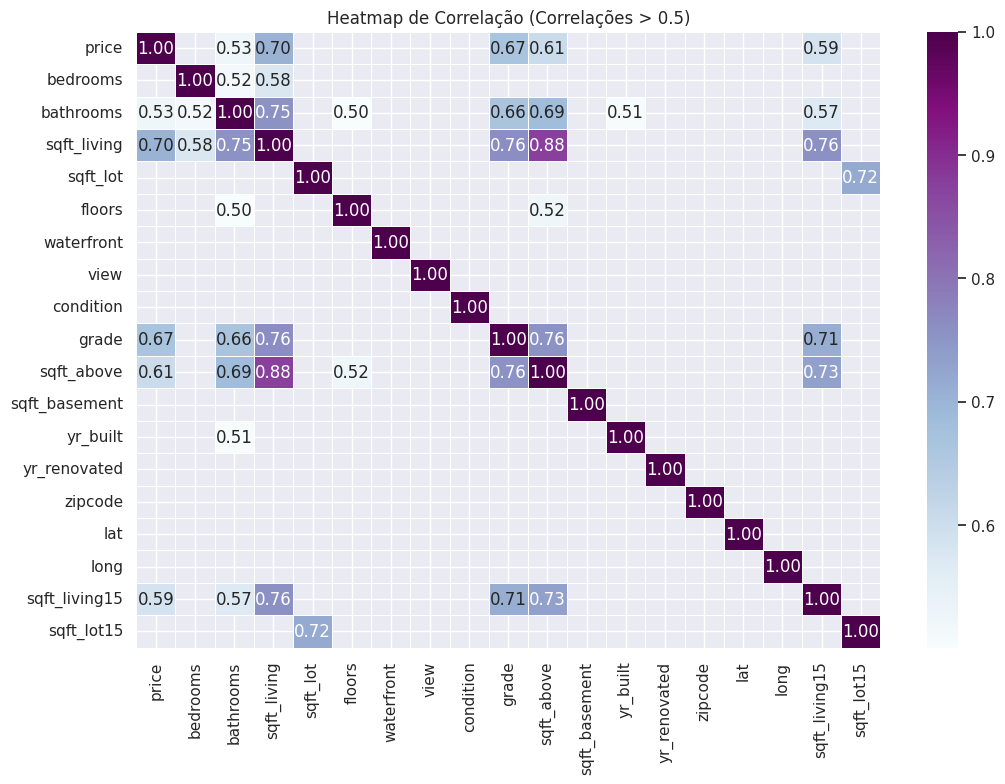

In [75]:
matriz_correlacao2 = sales.corr()

# Filtra as correlações maiores que 0.5
correlacoes_filtradas = matriz_correlacao2[matriz_correlacao2 > 0.5]

# Cria um mapa de calor com as correlações filtradas
plt.figure(figsize=(12, 8))
sns.heatmap(correlacoes_filtradas, annot=True, cmap='BuPu', fmt=".2f", linewidths=0.5)
plt.title('Heatmap de Correlação (Correlações > 0.5)')
plt.show()

In [9]:
colunas = sales.columns.tolist()
colunas

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [24]:
colunas_drop = sales.columns.tolist()
colunas_drop.remove('yr_renovated')
colunas_drop.remove('zipcode')


o yr_renovated foi tirado devido aos zeros, mais abaixo sera feito um histograma onde esses valores serão retirados. O zipcode também foi retirado, pois não faria sentido olhar o histograma dessa variável

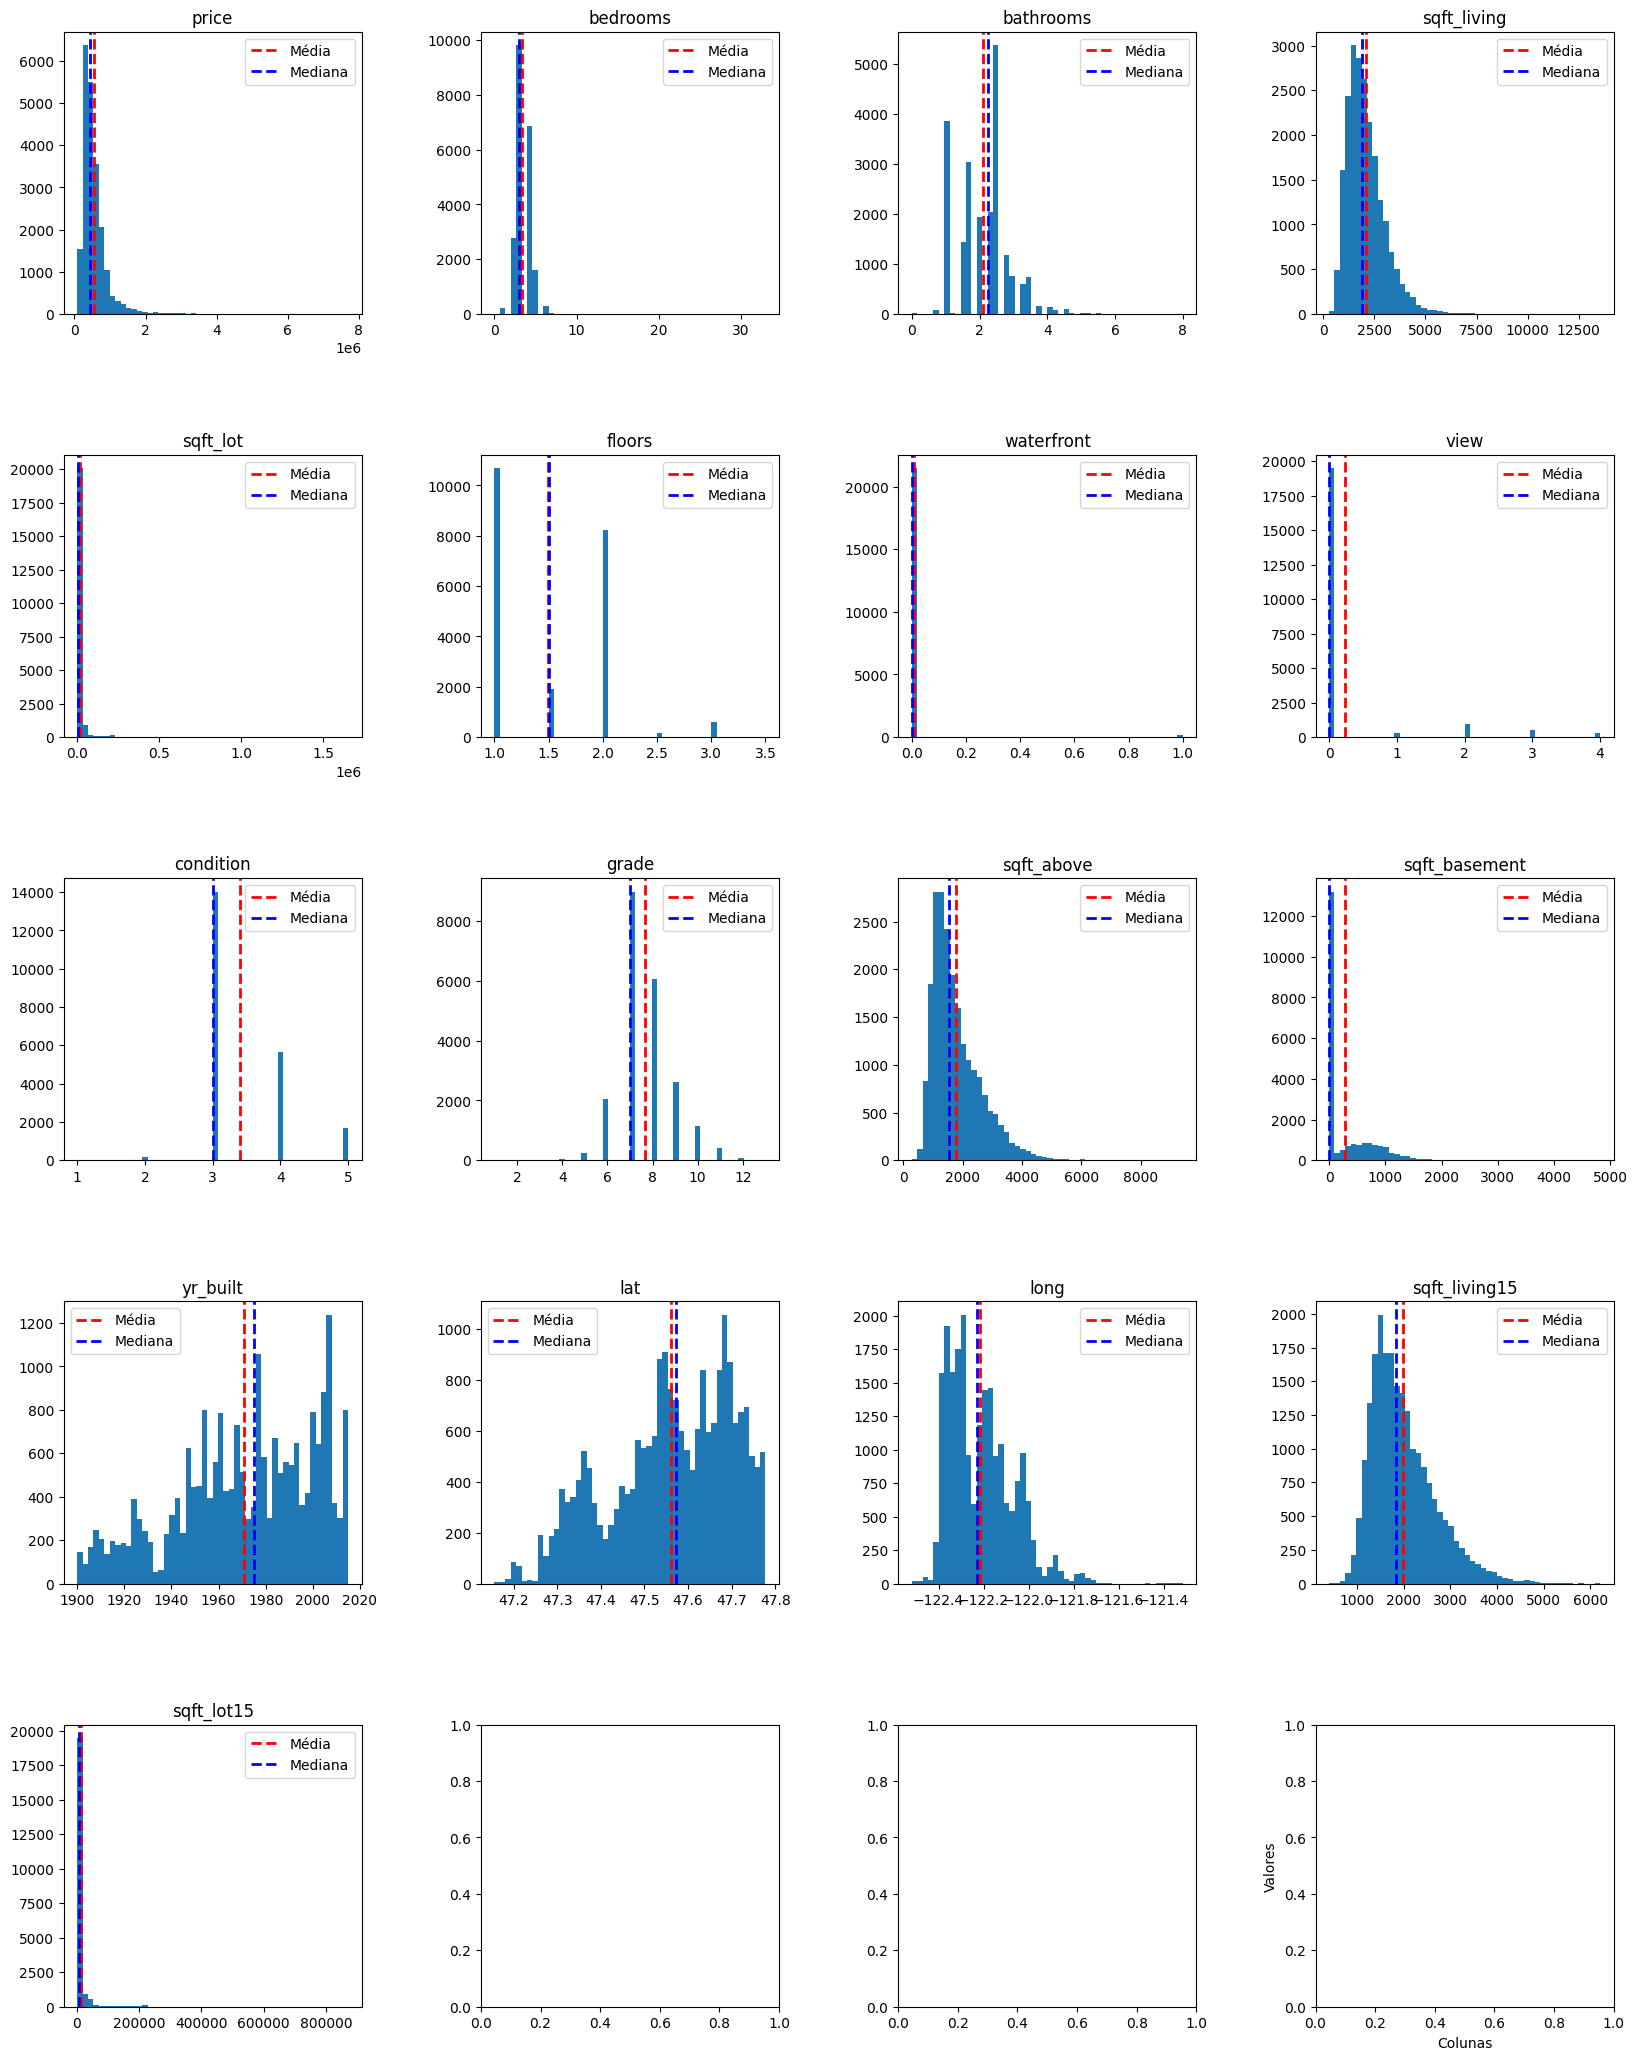

In [25]:

# Configuração dos subplots em 4 por linha
num_linhas = (len(colunas_drop) + 3) // 4  # Arredonda para cima
num_colunas = 4

# Criando subplots
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(20, 5 * num_linhas))

# Loop para criar boxplots em cada subplot
for i, col in enumerate(colunas_drop):
    row = i // num_colunas
    coluna = i % num_colunas
    axs[row, coluna].hist(sales[col], bins=50)
    
    # Adicione linha vertical para a média
    mean_value = sales[col].mean()
    axs[row, coluna].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Média')
    
    # Adicione linha vertical para a mediana
    median_value = sales[col].median()
    axs[row, coluna].axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label='Mediana')

    axs[row, coluna].set_title(col)
    axs[row, coluna].legend()


# Adiciona espaço entre os subplots
plt.subplots_adjust(top=0.9, hspace=0.5, wspace=0.4)

# Adiciona rótulos para os eixos
plt.xlabel('Colunas')
plt.ylabel('Valores')

# Exibe os gráficos
plt.show()


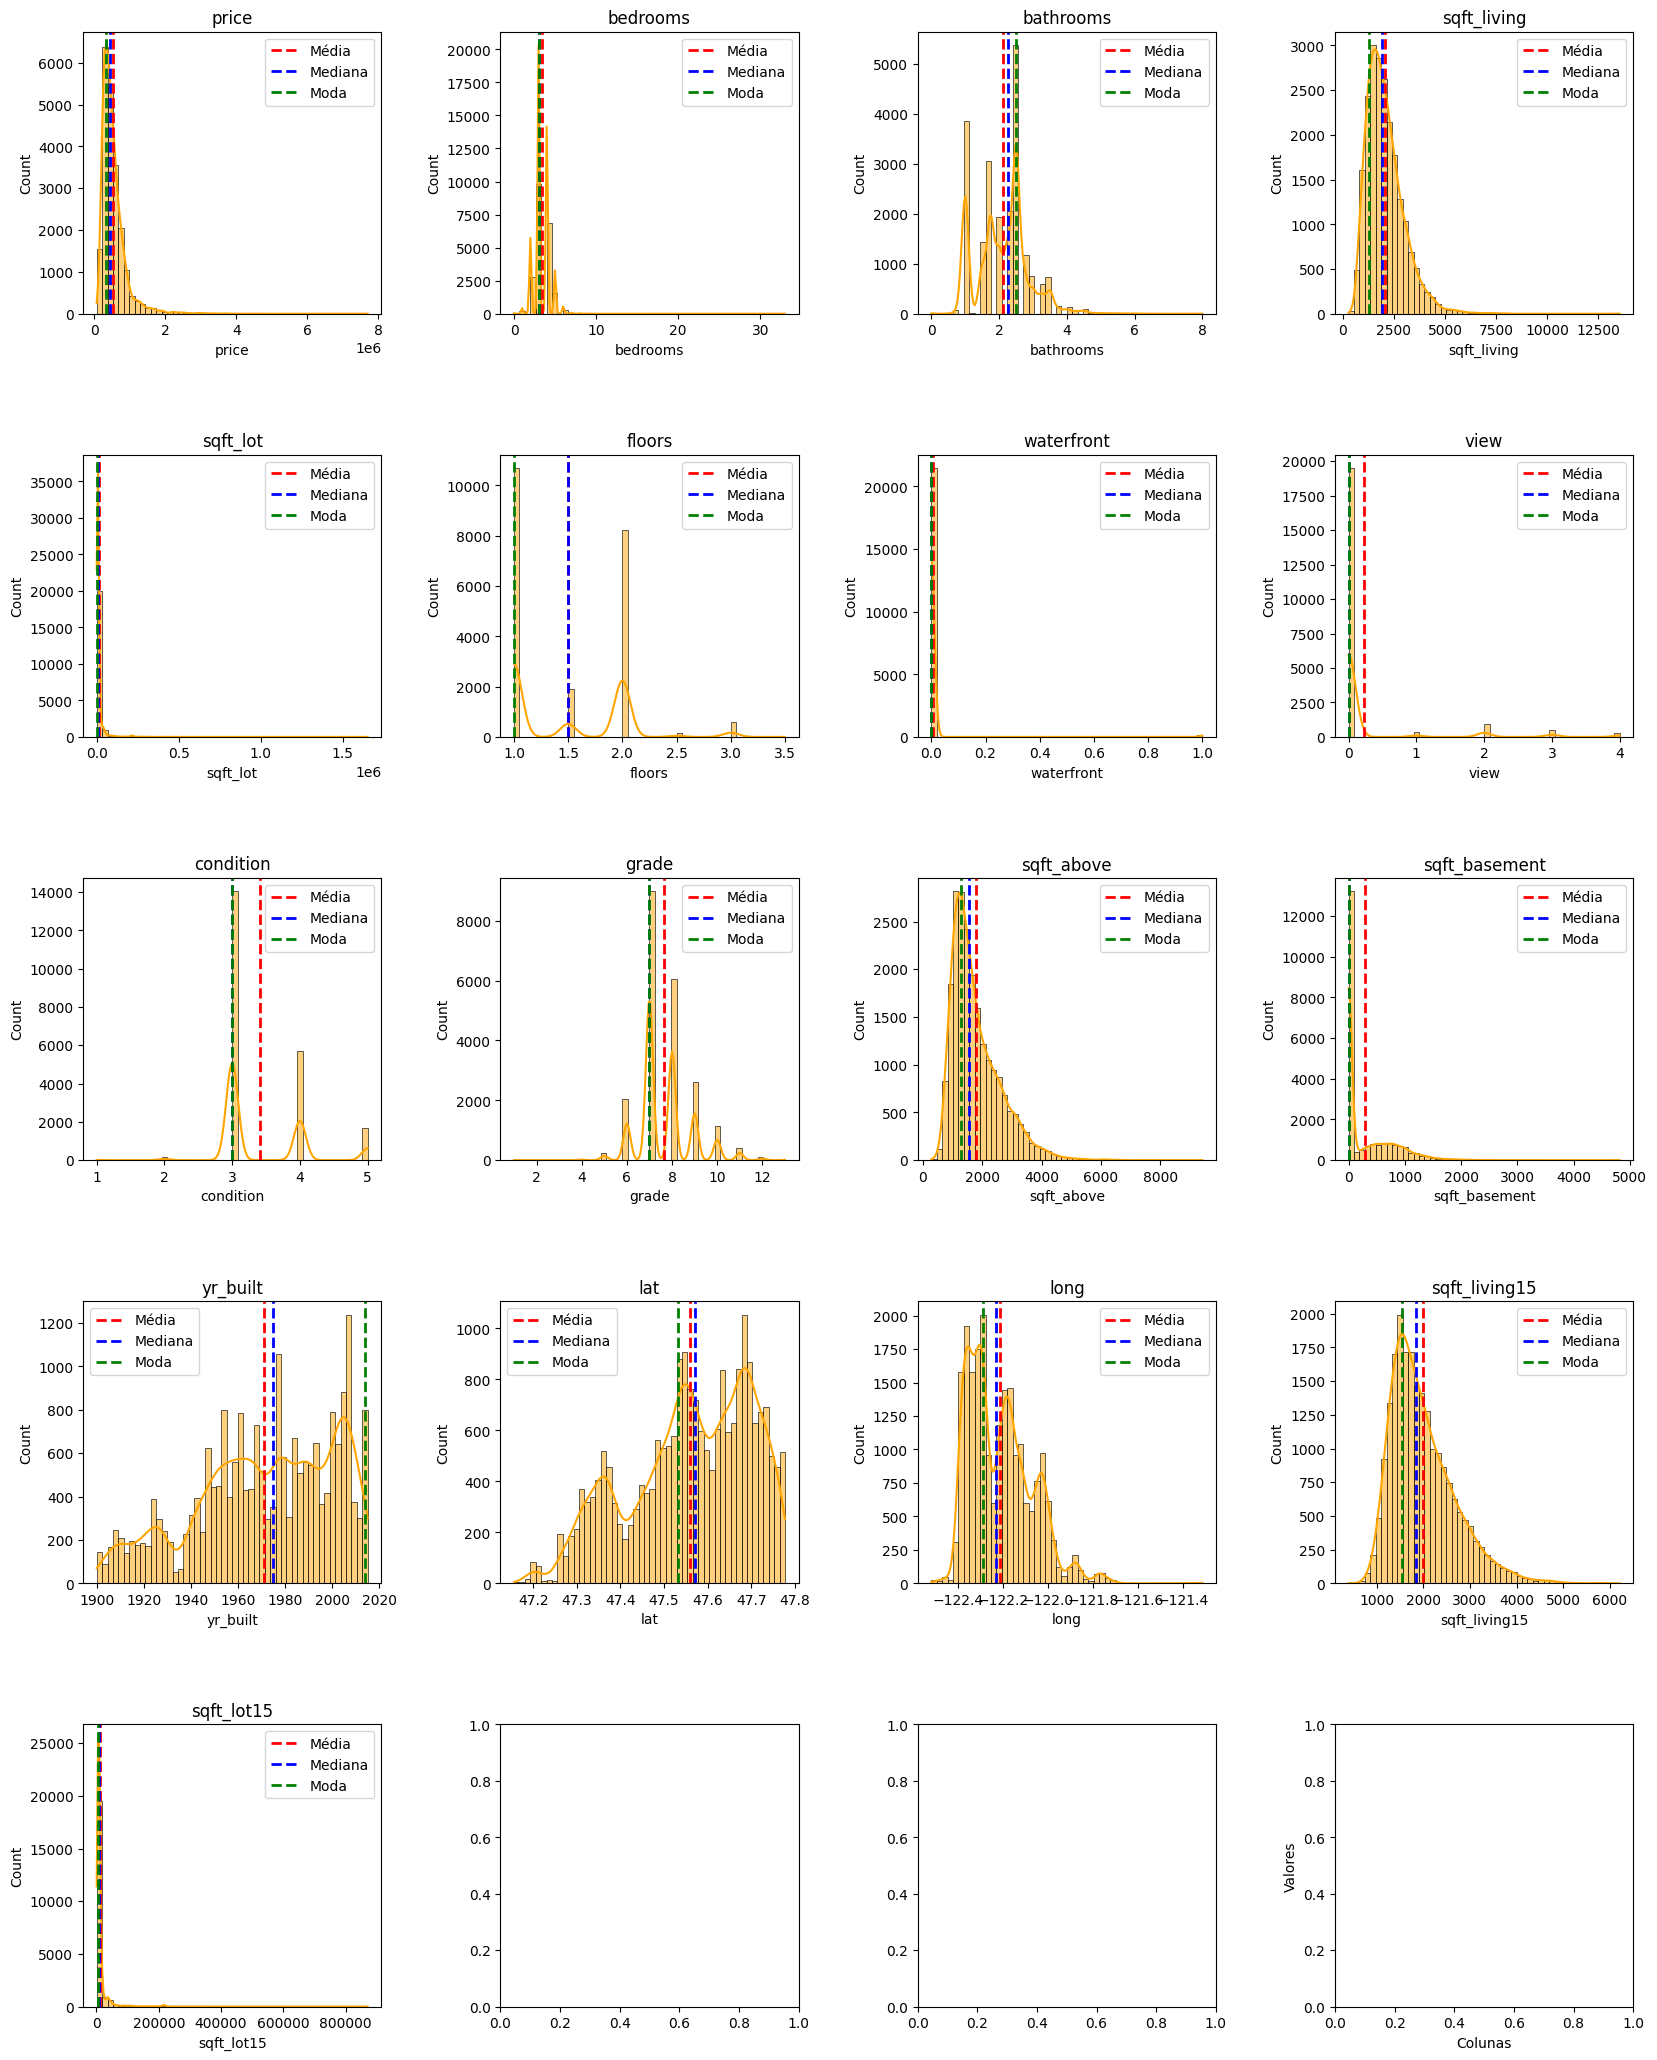

In [43]:

# Configuração dos subplots em 4 por linha
num_linhas = (len(colunas_drop) + 3) // 4  # Arredonda para cima
num_colunas = 4

# Criando subplots
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(20, 5 * num_linhas))

# Loop para criar boxplots em cada subplot
for i, col in enumerate(colunas_drop):
    row = i // num_colunas
    coluna = i % num_colunas
    sns.histplot(sales[col], bins=50, kde=True, ax=axs[row, coluna], color='orange')    
    # Adicione linha vertical para a média
    mean_value = sales[col].mean()
    axs[row, coluna].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Média')
    
    # Adicione linha vertical para a mediana
    median_value = sales[col].median()
    axs[row, coluna].axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label='Mediana')

    mode_value = sales[col].mode().iloc[0]  # Pode haver mais de uma moda, escolha a primeira
    axs[row, coluna].axvline(mode_value, color='green', linestyle='dashed', linewidth=2, label='Moda')

    axs[row, coluna].set_title(col)
    axs[row, coluna].legend()


# Adiciona espaço entre os subplots
plt.subplots_adjust(top=0.9, hspace=0.5, wspace=0.4)

# Adiciona rótulos para os eixos
plt.xlabel('Colunas')
plt.ylabel('Valores')

# Exibe os gráficos
plt.show()


In [47]:
from scipy.stats import kurtosis


for col in colunas_drop:
    # Calcula a curtose
    curtose = kurtosis(sales[col])
    
    print(f'Curtose para a coluna {col}: {curtose}')

Curtose para a coluna price: 34.577262255687536
Curtose para a coluna bedrooms: 49.05202582325276
Curtose para a coluna bathrooms: 1.2793287699931106
Curtose para a coluna sqft_living: 5.241602521613769
Curtose para a coluna sqft_lot: 285.01159582778826
Curtose para a coluna floors: -0.48488840505286346
Curtose para a coluna waterfront: 127.602691092139
Curtose para a coluna view: 10.89022423385801
Curtose para a coluna condition: 0.5253643439848448
Curtose para a coluna grade: 1.1903789844878396
Curtose para a coluna sqft_above: 3.4012389779605696
Curtose para a coluna sqft_basement: 2.714668427210353
Curtose para a coluna yr_built: -0.657533026308136
Curtose para a coluna lat: -0.6764341498242992
Curtose para a coluna long: 1.0489805112706225
Curtose para a coluna sqft_living15: 1.5964487608061324
Curtose para a coluna sqft_lot15: 150.72795683083365


Filtrando o ano de renovação com os valores diferentes de 0

In [27]:
filtered_sales = sales[sales['yr_renovated'] != 0]


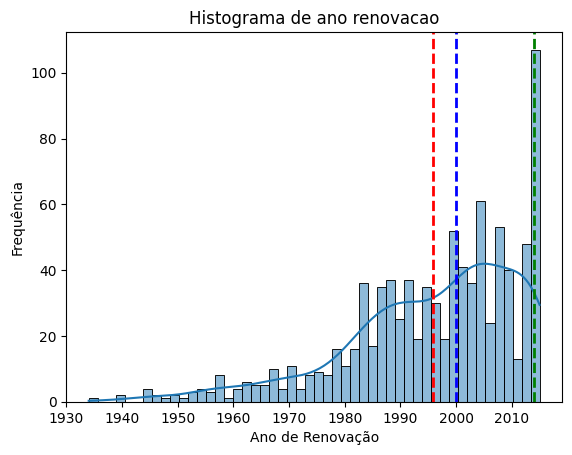

In [46]:
sns.histplot(filtered_sales['yr_renovated'], bins=50, edgecolor='black',kde=True)
mean_value = filtered_sales['yr_renovated'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Média')
median_value = filtered_sales['yr_renovated'].median()
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label='Mediana')

mode_value = filtered_sales['yr_renovated'].mode().iloc[0]
plt.axvline(mode_value, color='green', linestyle='dashed', linewidth=2, label='Mediana')

plt.title('Histograma de ano renovacao')
plt.xlabel('Ano de Renovação')
plt.ylabel('Frequência')
plt.show()

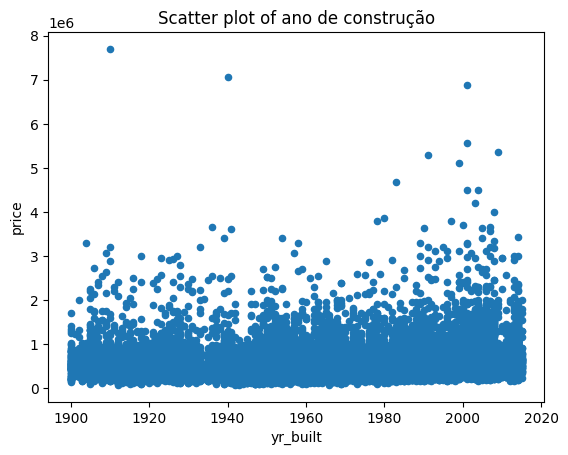

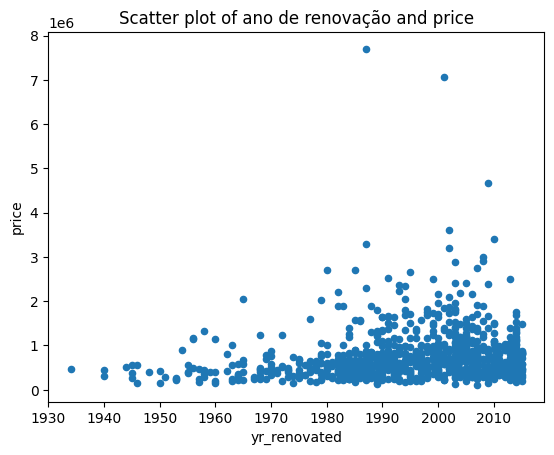

In [31]:
sales.plot.scatter(x='yr_built', y='price', title= 'Scatter plot of ano de construção');
filtered_sales.plot.scatter(x='yr_renovated', y='price', title= 'Scatter plot of ano de renovação and price');

As casas mais caras são mais antigas, mas foram renovadas

In [35]:
filtro_preco_maior_6milhoes = sales['price'] > 6000000
sales[filtro_preco_maior_6milhoes]

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
3914  7062500.0         5       4.50        10040     37325     2.0   
7252  7700000.0         6       8.00        12050     27600     2.5   
9254  6885000.0         6       7.75         9890     31374     2.0   

      waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
3914           1     2          3     11        7680           2360      1940   
7252           0     3          4     13        8570           3480      1910   
9254           0     4          3     13        8860           1030      2001   

      yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
3914          2001    98004  47.6500 -122.214           3930       25449  
7252          1987    98102  47.6298 -122.323           3940        8800  
9254             0    98039  47.6305 -122.240           4540       42730

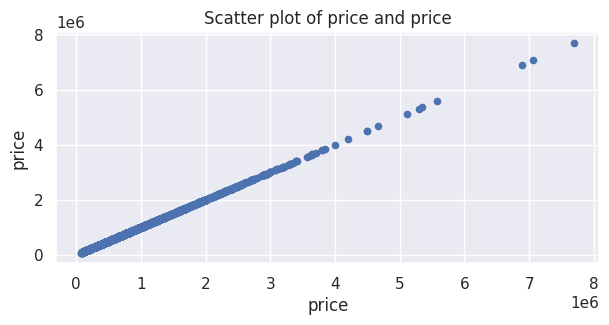

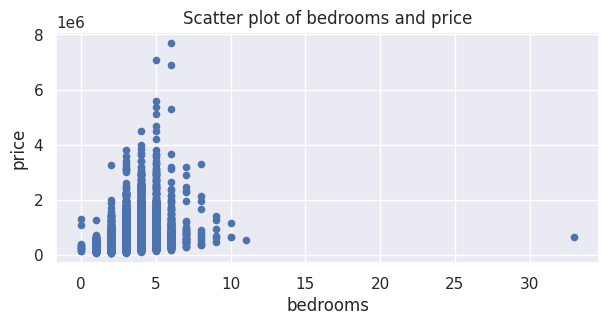

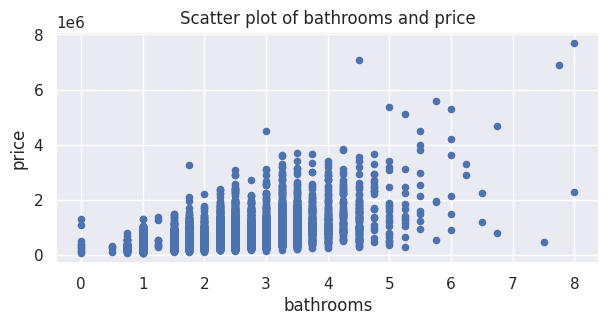

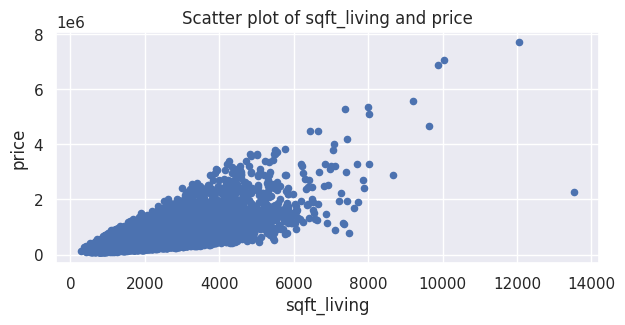

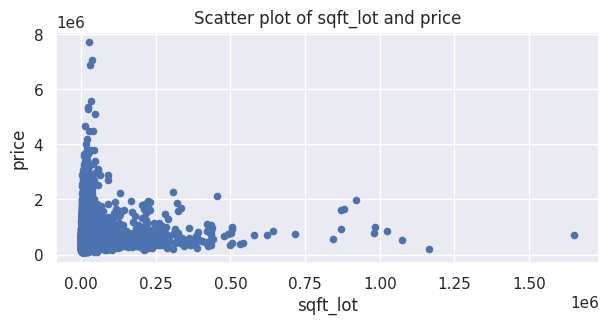

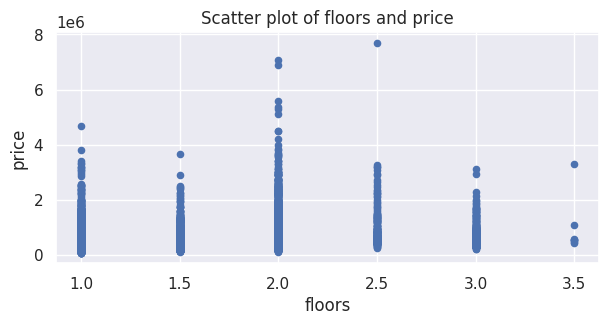

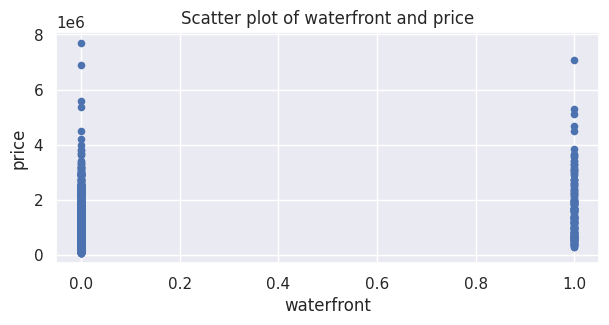

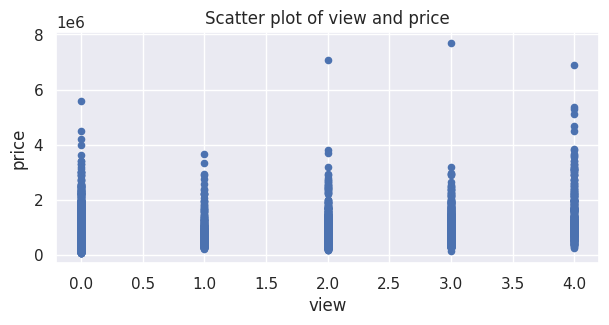

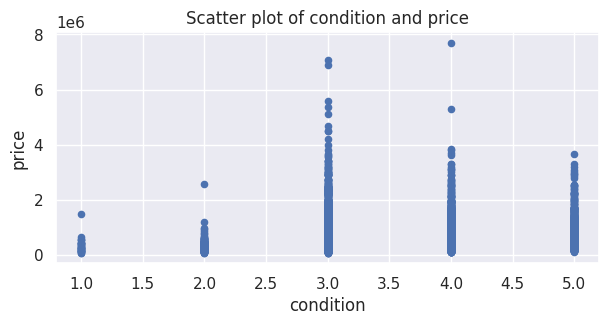

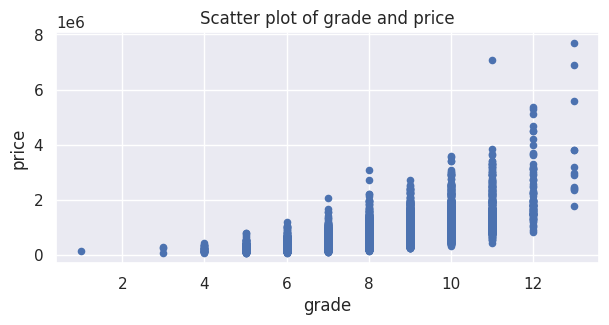

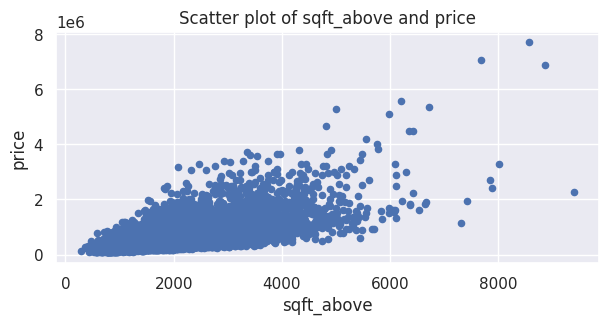

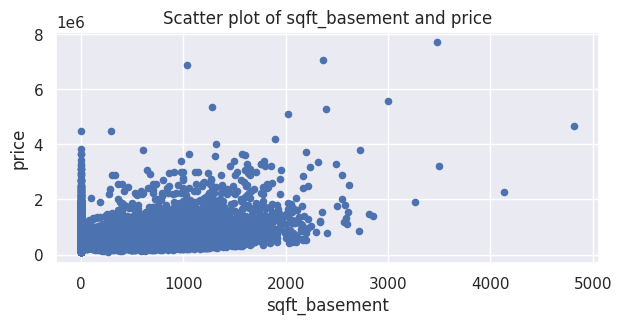

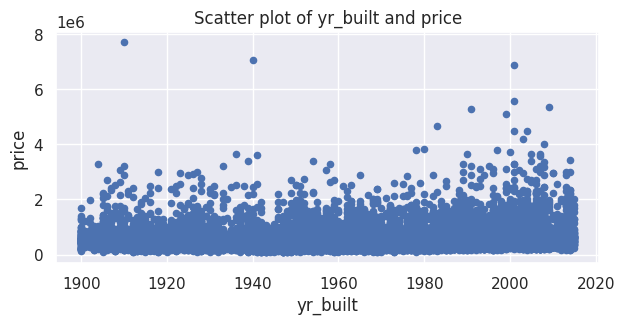

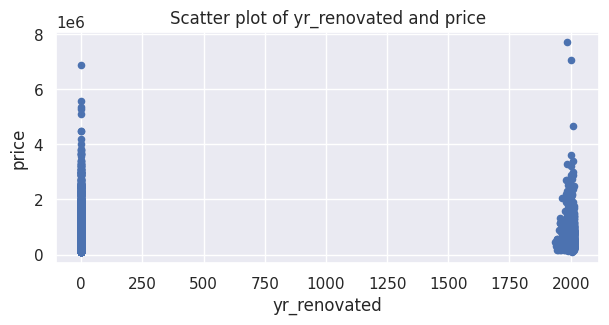

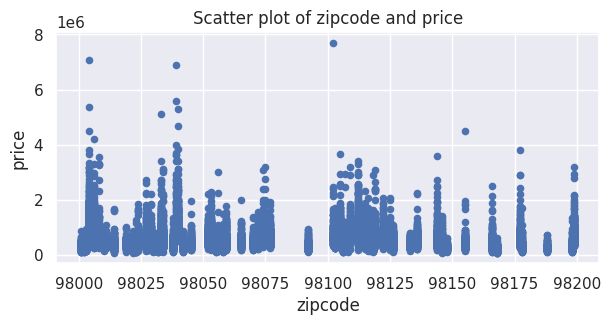

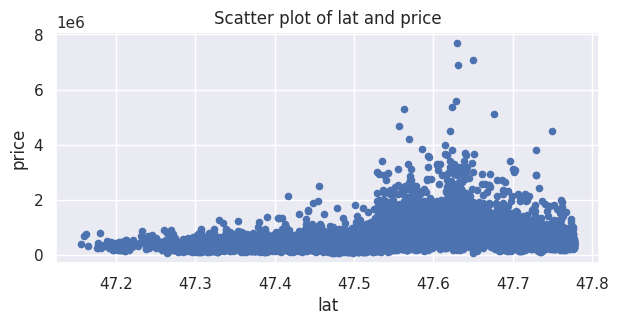

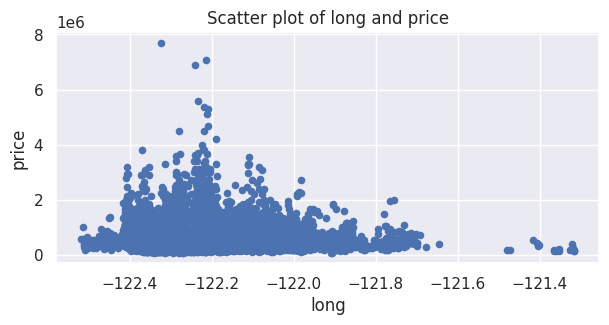

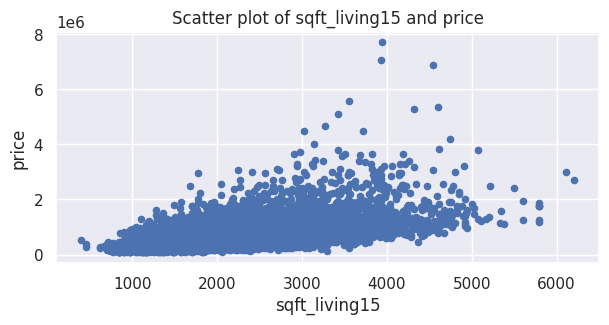

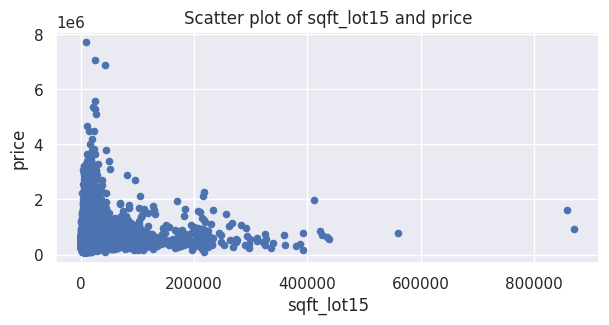

In [79]:
for col in sales[colunas]:
    sales.plot.scatter(x=col, y='price', title= 'Scatter plot of ' + col + ' and price');

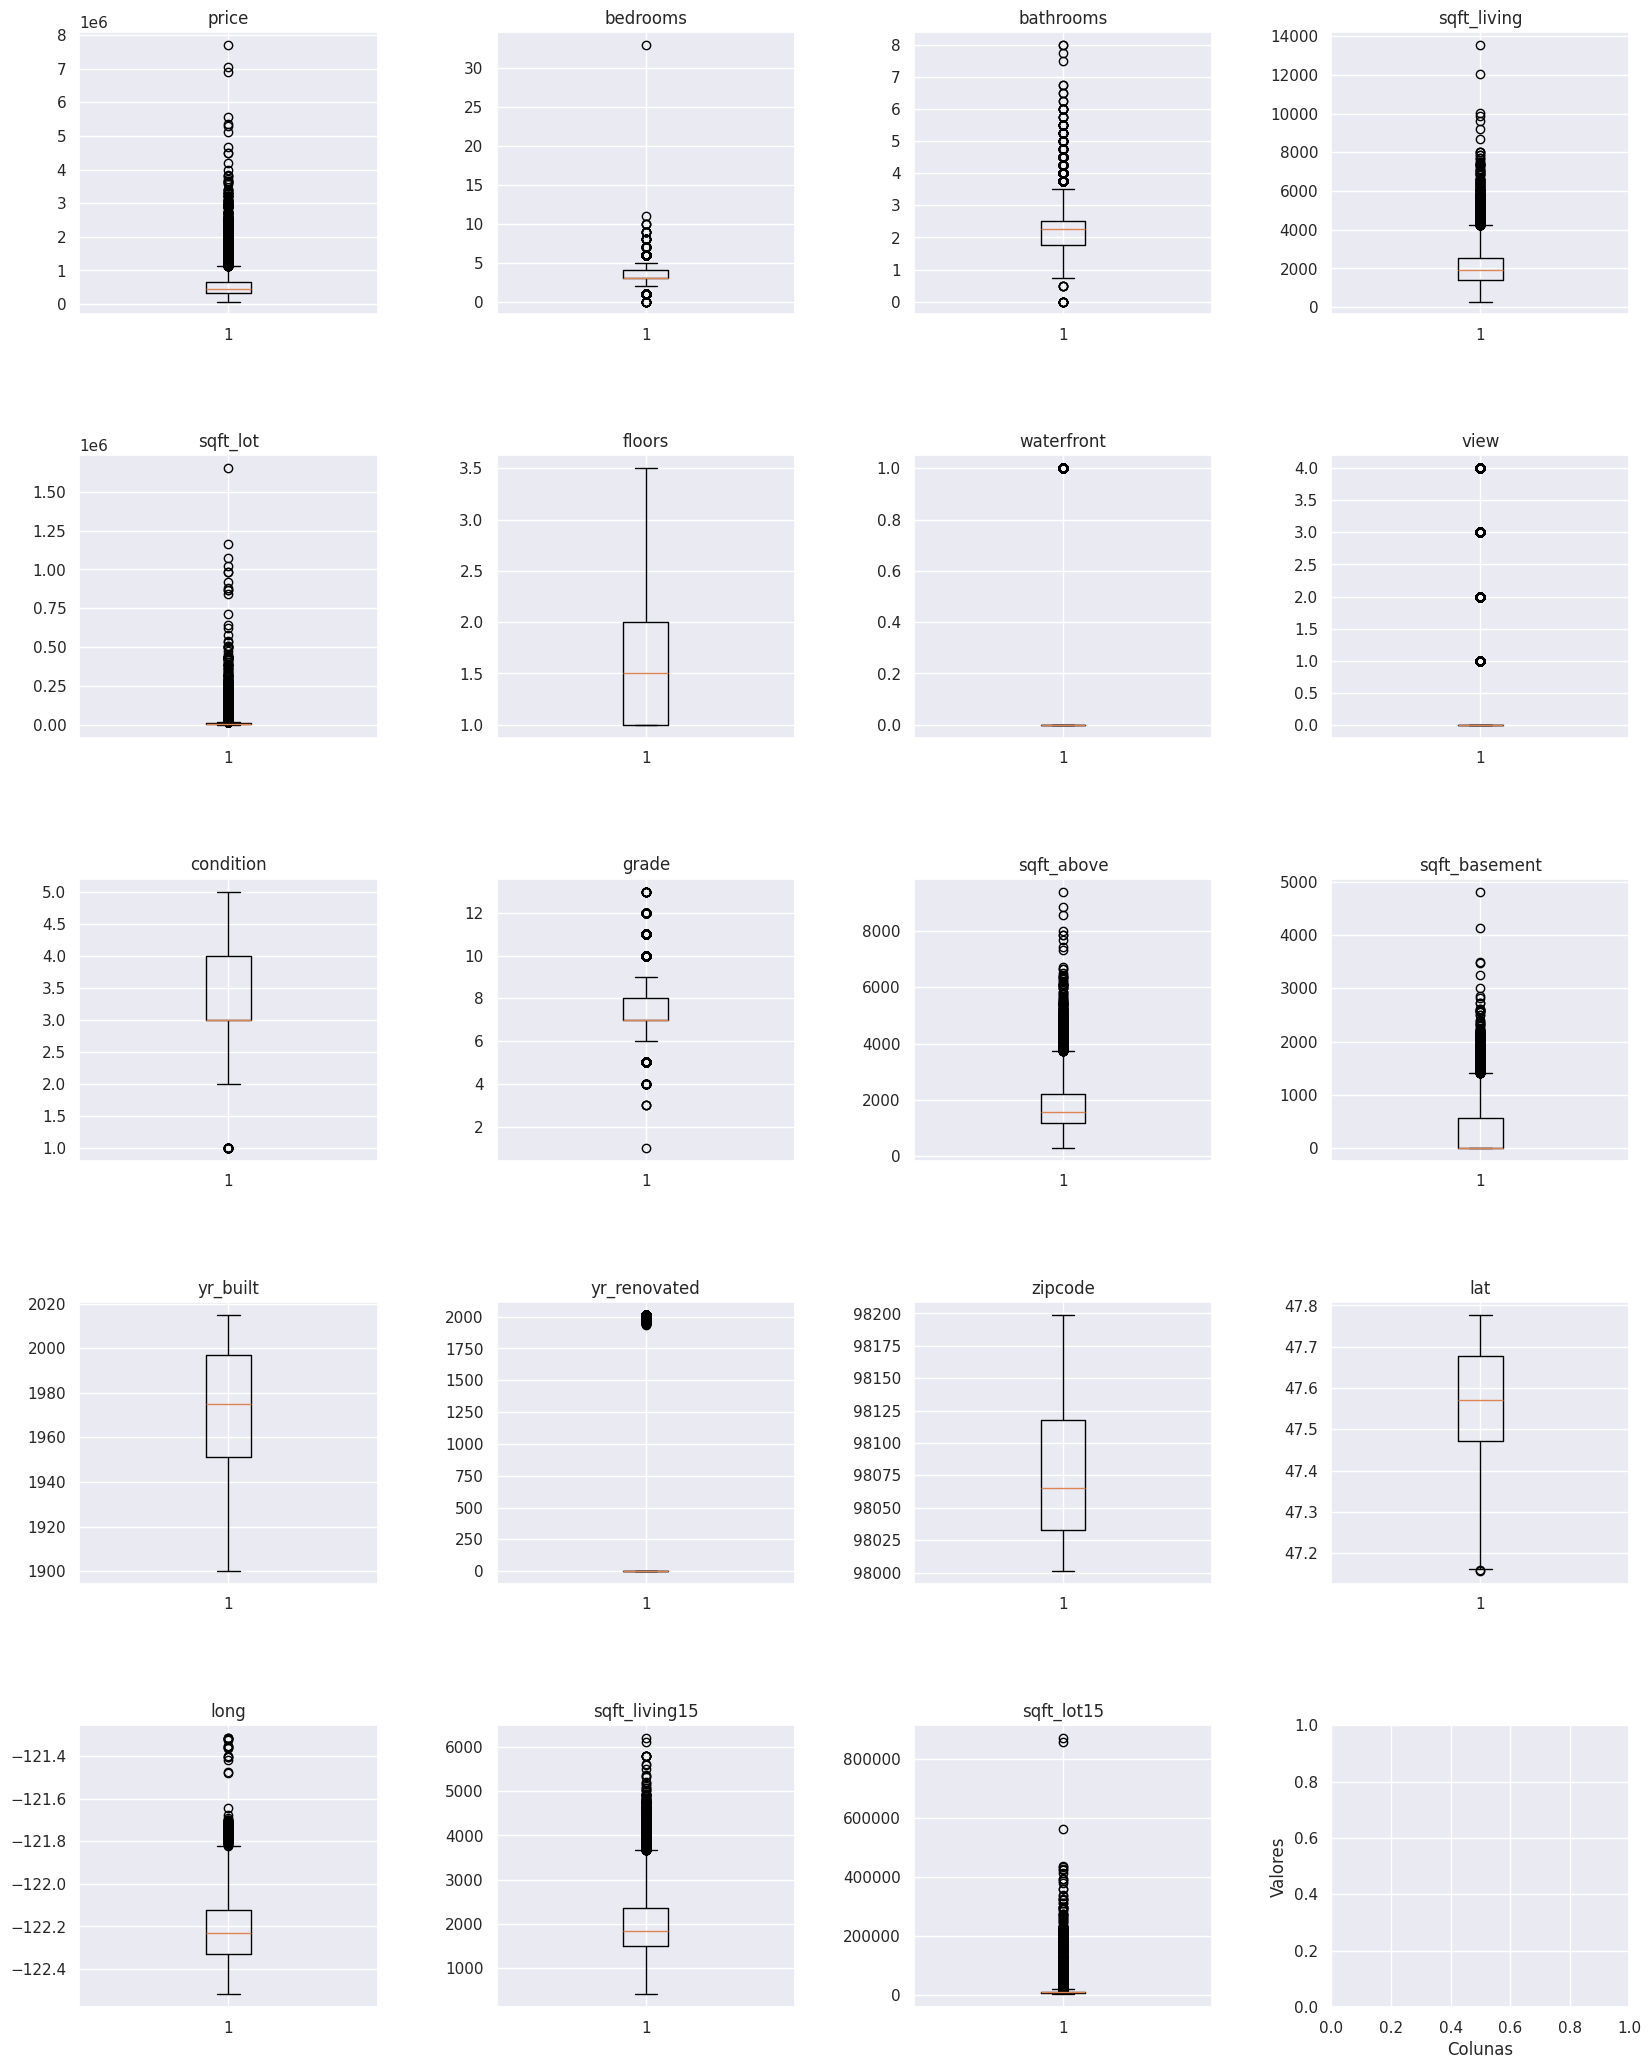

In [80]:
# Configuração dos subplots em 4 por linha
num_linhas = (len(colunas) + 3) // 4  # Arredonda para cima
num_colunas = 4

# Criando subplots
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(20, 5 * num_linhas))

# Loop para criar boxplots em cada subplot
for i, col in enumerate(colunas):
    row = i // num_colunas
    coluna = i % num_colunas
    axs[row, coluna].boxplot(sales[col])
    axs[row, coluna].set_title(col)

# Adiciona espaço entre os subplots
plt.subplots_adjust(top=0.9, hspace=0.5, wspace=0.4)

# Adiciona rótulos para os eixos
plt.xlabel('Colunas')
plt.ylabel('Valores')

# Exibe os gráficos
plt.show()

Conforme análise anterior existem muitos valores **yr_renovated** e **sqft_basement** iguais a 0
o mesmo acontece com waterfront e view, mas esses são valores de notas. 

In [83]:
# Mapear valores para categorias
def categorizar_grade(valor):
    if valor in range(1, 4):
        return 'Baixo'
    elif valor in range(4, 7):
        return 'Baixo_Médio'
    elif valor in range(7, 11):
        return 'Médio-Alta'
    elif valor in range(11, 14):
        return 'Alta qualidade'
    else:
        return 'Categoria Desconhecida'

# Criar uma nova coluna 'grade_categorizada'
sales['grade_categorizada'] = sales['grade'].apply(categorizar_grade)


In [84]:
sales.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  538000.0         3       2.25         2570      7242     2.0           0   
2  180000.0         2       1.00          770     10000     1.0           0   
3  604000.0         4       3.00         1960      5000     1.0           0   
4  510000.0         3       2.00         1680      8080     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      7        2170            400      1951          1991   
2     0          3      6         770              0      1933             0   
3     0          5      7        1050            910      1965             0   
4     0          3      8        1680              0      1987             0   

   zipcode      lat     long  sqft_living15  sqft_lot15 grade_categorizada  
0    98178  47.5112 -122.257           1340        5650         Médio-Alta  
1    98125  47.7210 -122.319           1690        7639         Médio-Alta  
2    98028  47.7379 -122.233           2720        8062        Baixo_Médio  
3    98136  47.5208 -122.393           1360        5000         Médio-Alta  
4    98074  47.6168 -122.045           1800        7503         Médio-Alta

In [10]:
sales['ano_renovacao_alterado'] = np.where(sales['yr_renovated'] != 0,
                                                           sales['yr_renovated'],
                                                           sales['yr_built'])


In [30]:
sns.boxplot(sales['ano_renovacao_alterado'])
plt.figure(figsize=(8, 6))
plt.hist(sales['ano_renovacao_alterado'], bins=50, edgecolor='black')
plt.title('Histograma de ano renovacao ou construção')
plt.xlabel('Ano de Renovação ou construção')
plt.ylabel('Frequência')
plt.show()



KeyError: 'ano_renovacao_alterado'

<Axes: title={'center': ' yr_built por localização'}, xlabel='long', ylabel='lat'>

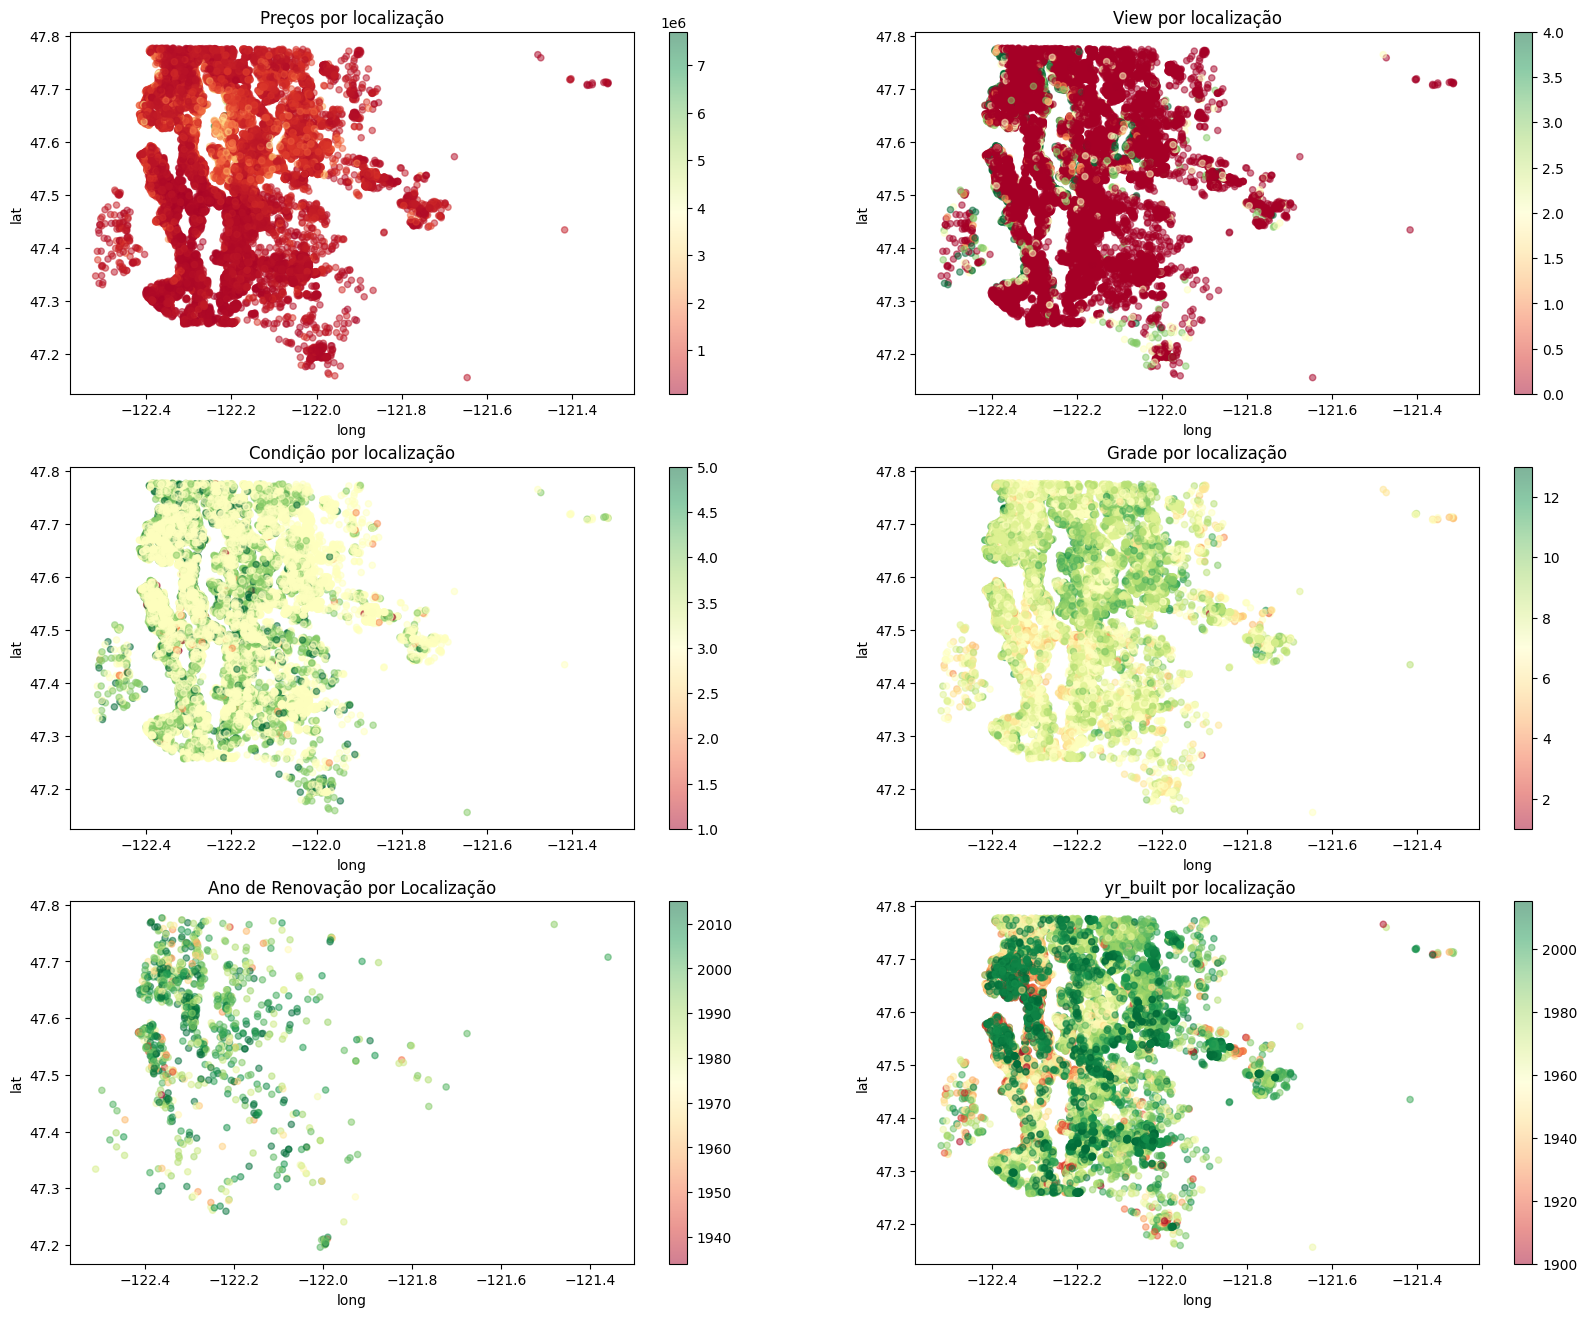

In [25]:
fig, ax=plt.subplots(3,2, figsize=(20,16))
sales.plot.scatter(y='lat',x='long',c=sales['price'],cmap ='RdYlGn', 
                   alpha=0.5,title = "Preços por localização",ax=ax[0,0])
sales.plot.scatter(y='lat',x='long',c=sales['view'],cmap ='RdYlGn', 
                   alpha=0.5,title = "View por localização",ax=ax[0,1])
sales.plot.scatter(y='lat',x='long',c=sales['condition'],cmap ='RdYlGn', 
                   alpha=0.5,title = "Condição por localização",ax=ax[1,0])
sales.plot.scatter(y='lat',x='long',c=sales['grade'],cmap ='RdYlGn', 
                   alpha=0.5,title = "Grade por localização",ax=ax[1,1])
filtered_sales = sales[sales['yr_renovated'] != 0]
filtered_sales.plot.scatter(x='long', y='lat', c=filtered_sales['yr_renovated'], 
                            cmap='RdYlGn', alpha=0.5, title="Ano de Renovação por Localização", ax=ax[2,0])
sales.plot.scatter(y='lat',x='long',c=sales['yr_built'],cmap ='RdYlGn', 
                   alpha=0.5,title = " yr_built por localização",ax=ax[2,1])

<Axes: title={'center': 'Vista para o mar existente por localização'}, xlabel='long', ylabel='lat'>

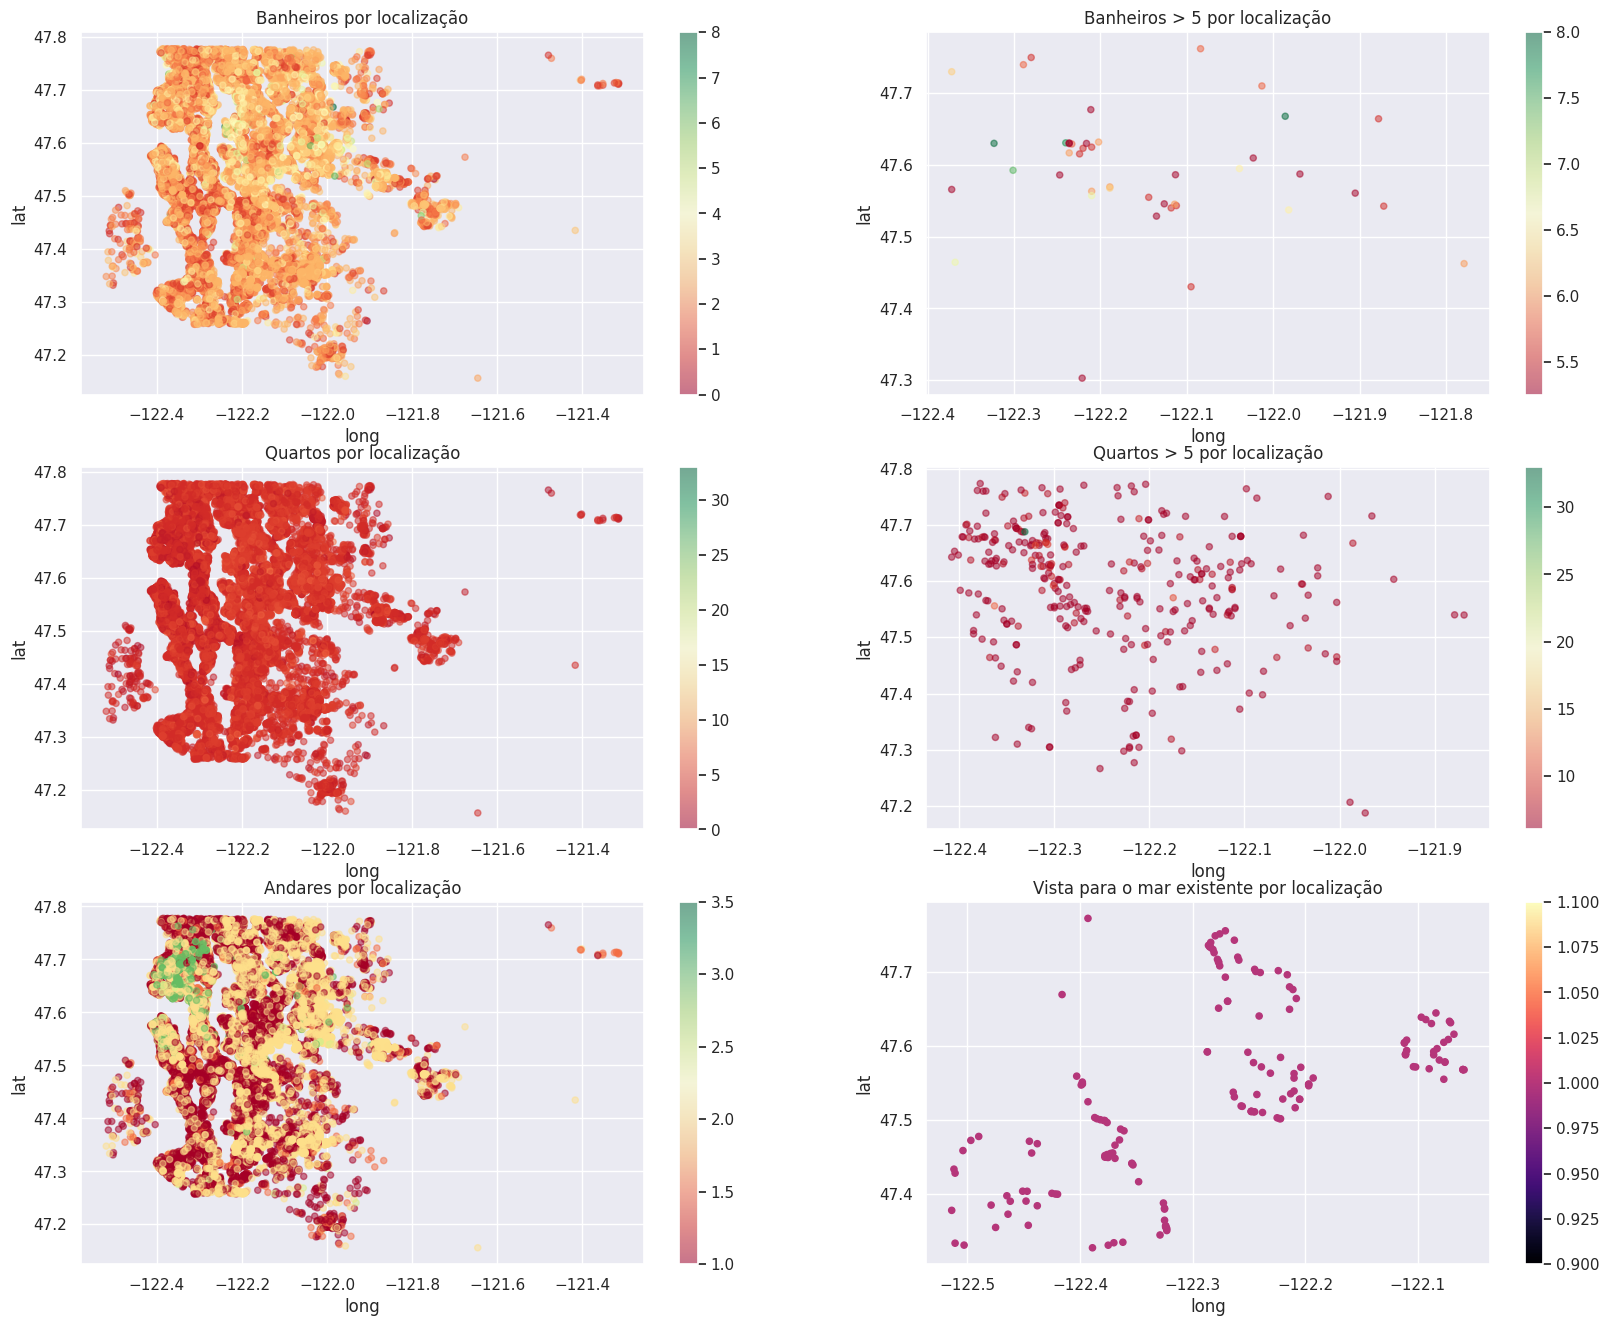

In [107]:
fig, ax=plt.subplots(3,2, figsize=(20,16))
sales.plot.scatter(y='lat',x='long',c=sales['bathrooms'],cmap ='RdYlGn', 
                   alpha=0.5,title = "Banheiros por localização",ax=ax[0,0])

filtered_bath = sales[sales['bathrooms'] > 5]
filtered_bath.plot.scatter(x='long', y='lat', c=filtered_bath['bathrooms'],cmap ='RdYlGn', 
                            alpha=0.5,title = "Banheiros > 5 por localização",ax=ax[0,1])

sales.plot.scatter(y='lat',x='long',c=sales['bedrooms'],cmap ='RdYlGn', 
                   alpha=0.5,title = "Quartos por localização",ax=ax[1,0])
filtered_bed = sales[sales['bedrooms'] > 5]
filtered_bed.plot.scatter(x='long', y='lat', c=filtered_bed['bedrooms'], cmap ='RdYlGn', 
                    alpha=0.5,title = "Quartos > 5 por localização",ax=ax[1,1])

sales.plot.scatter(y='lat',x='long',c=sales['floors'], cmap ='RdYlGn',alpha=0.5,
                   title = "Andares por localização",ax=ax[2,0])

filtered_waterfront = sales[sales['waterfront'] !=0]

filtered_waterfront.plot.scatter(y='lat',x='long',c=filtered_waterfront['waterfront'],cmap ='magma'
                   ,title = "Vista para o mar existente por localização",ax=ax[2,1])



/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


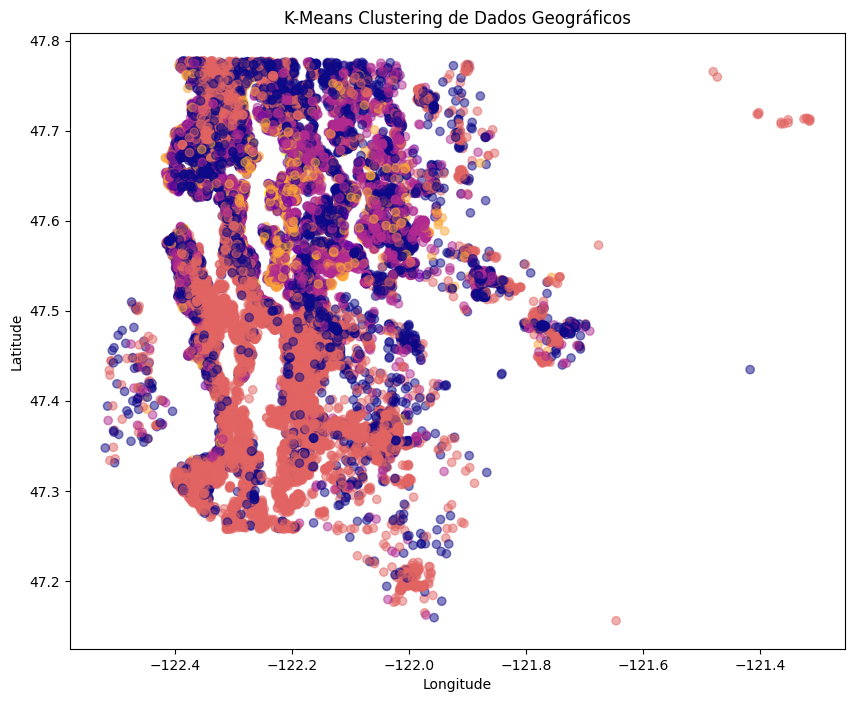

In [11]:

from sklearn.cluster import KMeans

# Selecionar variáveis relevantes para clustering
X = sales[['lat', 'long', 'price']]

# Aplicar K-Means
kmeans = KMeans(n_clusters=6, random_state=42)
sales['cluster'] = kmeans.fit_predict(X)

# Visualizar os clusters no mapa
plt.figure(figsize=(10, 8))
plt.scatter(sales['long'], sales['lat'], c=sales['cluster'], cmap='plasma', alpha=0.5)
plt.title('K-Means Clustering de Dados Geográficos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
 

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 1

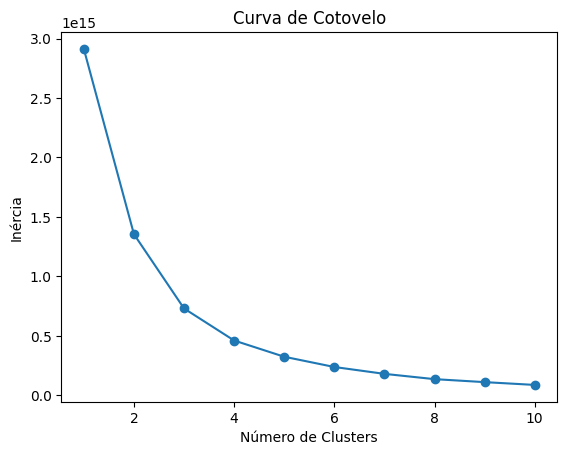

In [4]:
X = sales[['lat', 'long', 'price']]

n_clusters_range = range(1, 11)
inertia_values = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plotar a curva de cotovelo
plt.plot(n_clusters_range, inertia_values, marker='o')
plt.title('Curva de Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.show()

In [8]:
cluster_stats = sales.groupby('cluster')['price'].describe()
cluster_stats



count          mean           std        min        25%        50%  \
cluster                                                                        
0        7359.0  4.942715e+05  6.506358e+04   392000.0   437500.0   489950.0   
1         442.0  1.686269e+06  1.932611e+05  1405000.0  1525000.0  1650000.0   
2        4032.0  7.474094e+05  8.638889e+04   621500.0   674000.0   735000.0   
3        8397.0  2.885765e+05  6.418042e+04    75000.0   245000.0   294900.0   
4         162.0  2.690708e+06  4.386997e+05  2193000.0  2331000.0  2537500.0   
5          11.0  5.531209e+06  1.174368e+06  4208000.0  4584000.0  5300000.0   
6        1210.0  1.121306e+06  1.385173e+05   935100.0   995000.0  1099690.0   

               75%        max  
cluster                        
0         550000.0   621138.0  
1        1821875.0  2187730.0  
2         812125.0   935000.0  
3         340000.0   391500.0  
4        2974750.0  4000000.0  
5        6227500.0  7700000.0  
6        1237200.0  1400000.0

In [90]:
features = sales.columns.tolist()
features.remove("price")
X= sales[features]
y = sales["price"]
